In [1]:
import pandas as pd
import random
import math

# read in time point 1 for training
# train on it - model 1
# test on tp 2
# read tp 2
# add it to xgb - model 2
# test on tp 3
# read tp 3
# add it to xgb - model 3
# test on tp 4
# test model 1
data = pd.read_csv('~/ctgan/data/SD_Beresford_1999_to_2010_no02_no05_no06_mv_classs_stat_hdr_idx.csv')
data.head()

,index,yield,radiation,rain,avg_min_temp,avg_max_temp,class
0,1,-0.865484,353675.05,2161.05,3.123339,15.750222,1
1,2,-0.167419,368592.85,2298.69,3.430704,16.070378,1
2,3,-0.272903,378364.79,2362.68,3.738791,16.351024,1
3,4,-0.121613,390791.26,2451.11,4.072745,16.689902,0
4,5,0.512490,126696.15,853.02,1.696793,13.917601,1


In [2]:
# from sdv.tabular import TVAE

# model = TVAE()
# model.fit(data)

samples_out = 10000 # total number of samples/records to generate/synthesize
no_stds = 1.05 # number of standard deviations within which synthesized values must fall
number_of_classes = (data['class'].unique()).size # number of unique classes in input data

data_len = len(data.index)
F = [] # a list of the feature vectors dataframes, one per class
for class_no in range(number_of_classes):
    df = pd.DataFrame(data[data['class'] == class_no])
    F.append(df)

    
def synthesize_tabular_data(F, samples_out, no_stds, no_classes, no_records):
    new_F = []
    for index, entry in enumerate(F):
        yield_ = entry['yield']
        mean_yield = yield_.mean()
        std_yield = yield_.std()
        total_rad = entry['radiation']
        mean_rad = total_rad.mean()
        std_rad = total_rad.std()
        total_rain = entry['rain']
        mean_rain = total_rain.mean()
        std_rain = total_rain.std()
        avg_max_temp = entry['avg_max_temp']
        mean_max_temp = avg_max_temp.mean()
        std_max_temp = avg_max_temp.std()
        avg_min_temp = entry['avg_min_temp']
        mean_min_temp = avg_min_temp.mean()
        std_min_temp = avg_min_temp.std()
        
        new_yields = []
        new_rads = []
        new_rains = []
        new_max_temps = []
        new_min_temps = []
        
        # calculate potcii: percentage of this class in input
        potcii = (len(entry)/no_records)
        no_records_to_generate = round(potcii * samples_out)
        
        for i in range(no_records_to_generate):
            new_yield = random.uniform(mean_yield - std_yield*no_stds, mean_yield + std_yield*no_stds)
            new_yields.append(new_yield)
            
            new_rad = random.uniform(mean_rad - std_rad*no_stds, mean_rad + std_rad*no_stds)
            new_rads.append(new_rad)
            
            new_rain = random.uniform(mean_rain - std_rain*no_stds, mean_rain + std_rain*no_stds)
            new_rains.append(new_rain)
        
            new_max_temp = random.uniform(mean_max_temp - std_max_temp*no_stds, mean_max_temp + std_max_temp*no_stds)
            new_max_temps.append(new_max_temp)
            
            new_min_temp = random.uniform(mean_min_temp - std_min_temp*no_stds, mean_min_temp + std_min_temp*no_stds)
            new_min_temps.append(new_min_temp)
            
        concat_yields = pd.concat([yield_, pd.DataFrame(new_yields)])
        concat_rads = pd.concat([total_rad, pd.DataFrame(new_rads)])
        concat_rain = pd.concat([total_rain, pd.DataFrame(new_rains)])
        concat_max_temps = pd.concat([avg_max_temp, pd.DataFrame(new_max_temps)])
        concat_min_temps = pd.concat([avg_min_temp, pd.DataFrame(new_min_temps)])
        new_df = pd.DataFrame()
        new_df['yield'] = concat_yields
        new_df['radiation'] = concat_rads
        new_df['rain'] = concat_rain
        new_df['avg_max_temp'] = concat_max_temps
        new_df['avg_min_temp'] = concat_min_temps
        new_df['class'] = index
        print(index)
        new_F.append(new_df)
        
    return pd.concat(new_F)

new_data = synthesize_tabular_data(F, samples_out, no_stds, number_of_classes, data_len)

0
1
2


In [3]:
# new_data = model.sample(20000)

In [4]:
new_data.to_csv('data/SITS_10k_mv_0717_Beresford_1.csv')
new_data.head()

,yield,radiation,rain,avg_max_temp,avg_min_temp,class
3,-0.121613,390791.26,2451.11,16.689902,4.072745,0
6,-0.505032,152893.15,1063.42,16.124270,3.927039,0
10,0.645231,379100.41,2403.34,15.554727,2.784012,0
15,0.248000,170604.73,1286.11,17.730274,4.871311,0
18,-0.513467,263706.83,1779.96,16.695000,4.195669,0


In [5]:
# get aggregate data
targetDataLoc = '~/ctgan/ML_time_series_with_stationarity/data/SD_Beresford_2011_no02_no05_no06_mv_cuts_stationary_hdr_idx.csv'

targetDf = pd.read_csv(targetDataLoc) #pd.read_csv(targetDataLoc)
aggDf = new_data #data #pd.read_csv(aggDataLoc)
targetDf.head()

,index,yield,radiation,rain,avg_min_temp,avg_max_temp
0,1,-0.743846,238887.66,2095.41,1.958514,13.737066
1,2,-1.538654,249675.16,2203.16,2.438467,14.196432
2,3,0.365673,262000.33,2249.69,3.121411,14.858239
3,4,-0.286538,273082.13,2343.29,3.484750,15.271187


In [6]:
all_years_Loc = '~/ctgan/ML_time_series_with_stationarity/data/SD_Beresford_1999_to_2011_no02_no05_no06_mv_cuts_avgs_hdr_idx.csv'
all_yearsDf = pd.read_csv(all_years_Loc)
final_year_Loc = '~/ctgan/ML_time_series_with_stationarity/data/SD_Beresford_for_math_mv_4_averages_hdr_idx.csv'
final_yearDf = pd.read_csv(final_year_Loc)
final_yearDf.head()
target_year_Loc = '~/ctgan/ML_time_series_with_stationarity/data/SD_Beresford_2011_no02_no05_no06_mv_cuts_avgs_hdr_idx.csv'
target_yearDf = pd.read_csv(target_year_Loc)

In [7]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVC  # support vector machines classification
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier # neural network for classification
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # adaboost for classification
import xgboost as xgb
# saving models
# from sklearn.externals import joblib
import joblib

# import the API
APILoc = 'API/'

import sys
sys.path.insert(0, APILoc)

from API import *

In [8]:
# filter out the features that will not be used by the machine learning models

xColumnsToKeep = ["radiation", "rain", "avg_min_temp", "avg_max_temp"]

# the target to keep
yColumnsToKeep = ["yield"]

# get a dataframe containing the features and the targets
xDf = aggDf[xColumnsToKeep]
# not basing forecasted yields on forecast year's features
test_xDf = targetDf[xColumnsToKeep] 

yDf = aggDf[yColumnsToKeep]
test_yDf = targetDf[yColumnsToKeep]

target_yearDf = target_yearDf[yColumnsToKeep]

# reset the index
xDf = xDf.reset_index(drop=True)
yDf = yDf.reset_index(drop=True)
test_xDf = test_xDf.reset_index(drop=True)
test_yDf = test_yDf.reset_index(drop=True)
target_yearDf = target_yearDf.reset_index(drop=True)

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)

xCols = list(xDf)

In [9]:
# hide the warnings because training the neural network caues lots of warnings.
import warnings
warnings.filterwarnings('ignore')

# make the parameter grids for sklearn's gridsearchcv
rfParamGrid = {
        'model__n_estimators': [5, 10, 25, 50, 100], # Number of estimators
        'model__max_depth': [5, 10, 15, 20], # Maximum depth of the tree
        'model__criterion': ["mae"]
    }
knnParamGrid ={
        'model__n_neighbors':[2,5,10],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [5, 10, 30, 50]    
    }
svrParamGrid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 1.0, 5.0, 10.0],
        'model__gamma': ["scale", "auto"],
        'model__degree': [2,3,4,5]
    }
nnParamGrid = {
        'model__hidden_layer_sizes':[(3), (5), (10), (3,3), (5,5), (7,7)],
        'model__solver': ['sgd', 'adam'],
        'model__learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'model__learning_rate_init': [0.1, 0.01, 0.001]      
    }

linRegParamGrid = {}

bayesParamGrid={
        'model__n_iter':[100,300,500]
    }

dtParamGrid = {
    'model__criterion': ['mae'],
    'model__max_depth': [5,10,25,50,100]
    #'model__max_depth': [5,10,25]
    }

xgbParamGrid = {}

aModelList = [#(RandomForestRegressor(), rfParamGrid, "rfTup.pkl")]#,
              (KNeighborsRegressor(), knnParamGrid, "knnTup.pkl")]
              #(SVC(), svrParamGrid, "svrTup.pkl")]#,
             #(MLPRegressor(), nnParamGrid, "nnTup.pkl")]#,
             #(LinearRegression(), linRegParamGrid, "linRegTup.pkl")]#,
             #(BayesianRidge(), bayesParamGrid, "bayesTup.pkl"),
             #(DecisionTreeRegressor(), dtParamGrid, "dtTup.pkl")]
             #(xgb.XGBRegressor(), xgbParamGrid, "xgbTup.pkl")]

N = 10
workingDir = 'working_dir'
numFeatures = 4 # 11

model:  knnTup
Avg MAE:  1033.475
Avg R squared:  -0.011
Best MAE:  996.919
Best R squared:  0.034
 
test results on our test data: 
      yield
0 -0.743846
1 -1.538654
2  0.365673
3 -0.286538
[0.27918557 0.44034731 0.61259219 0.17523129]
adjusted predictions: 
[2.6285920439839314, 2.4786548753208106, 1.9698093469614408, 0.9957891130665445]
          0
0  2.628592
1  2.478655
2  1.969809
3  0.995789
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     17.41
Date:                Mon, 17 Jul 2023   Prob (F-statistic):             0.0529
Time:                        12:43:12   Log-Likelihood:                 2.8463
No. Observations:                   4   AIC:                            -1.693
Df Residuals:                       2   BIC:

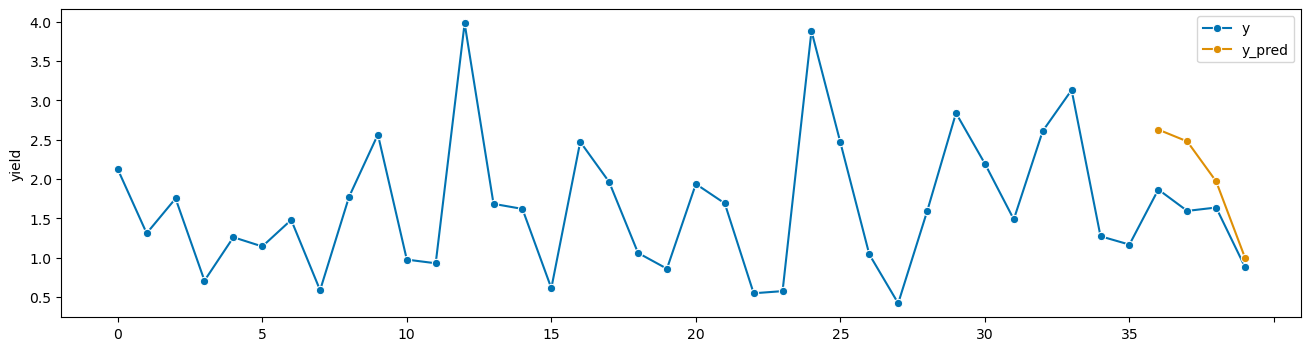

In [10]:
saveMLResults(all_yearsDf, final_yearDf, target_yearDf, test_xDf, test_yDf, N, xDf, yDf, aModelList, workingDir, numFeatures, printResults=True)